## Compare Synthetic with Observations

per pixel error estimates


In [1]:
import folium
import xskillscore as xs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import geopandas as gpd

import odc.geo.xr
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [13]:
model_var='NDVI'
name='nontrees'

In [14]:
yy = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_'+name+'_LGBM_harmonize_test_5km_monthly_2001_2013.nc')['NDVI']
# yy = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/Harmonized_NDVI_AVHRR_MODIS_1982_2013.nc')['ndvi_mcd_pred']
# yy = yy.sel(time=slice('2001', '2013'))

obs = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MODIS_NDVI_5km_monthly_2001_2022.nc')['NDVI_median']
obs.name='NDVI'
obs = obs.sel(time=yy.time)
# obs = obs.sel(time=slice('2001', '2013'))
# obs = obs[model_var].rename({'latitude':'y', 'longitude':'x'})
# gaps_mask = ~np.isnan(obs)

### Create a mask

In [15]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = assign_crs(trees, crs ='epsg:4326')
trees=trees.sel(time=slice('2001', '2018'))
trees=trees.odc.reproject(how=yy.odc.geobox)
trees = trees.mean('time')

if name=='trees':
    mask = xr.where(trees>0.5, 1, 0)
if name=='nontrees':
    mask = xr.where(trees<=0.5, 1, 0)

avhrr_mask = ~np.isnan(yy)

# yy = yy.where(mask)
obs = obs.where(avhrr_mask)

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


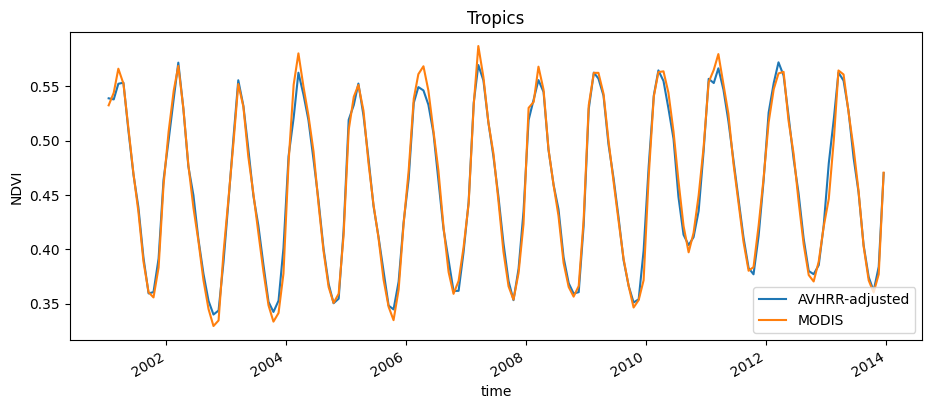

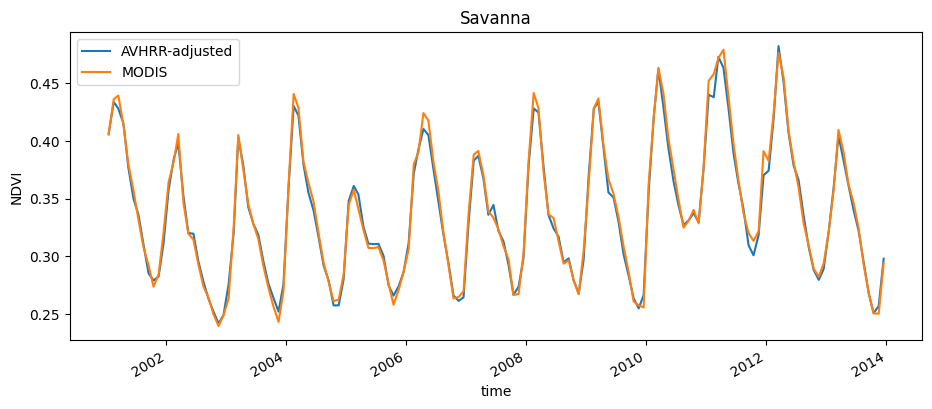

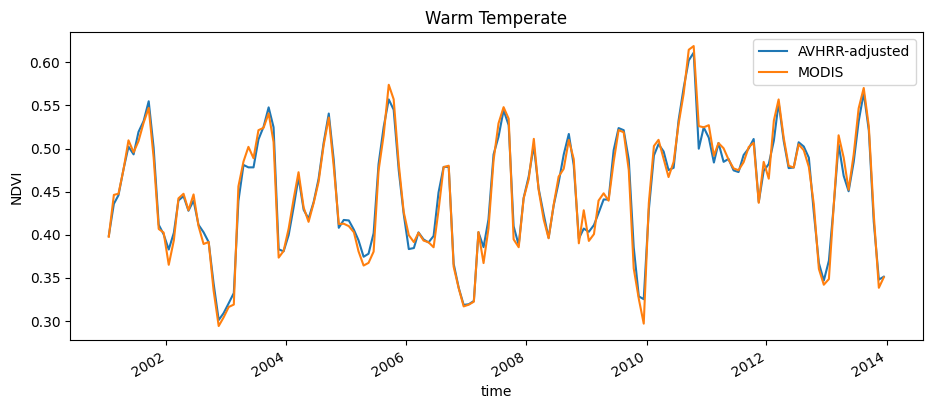

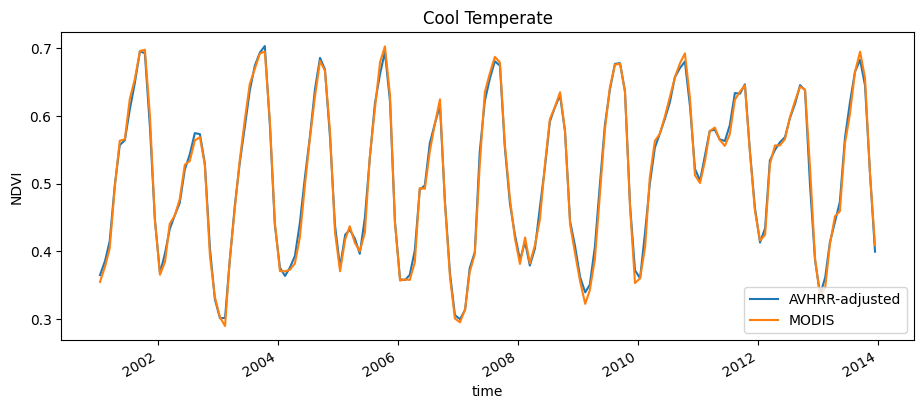

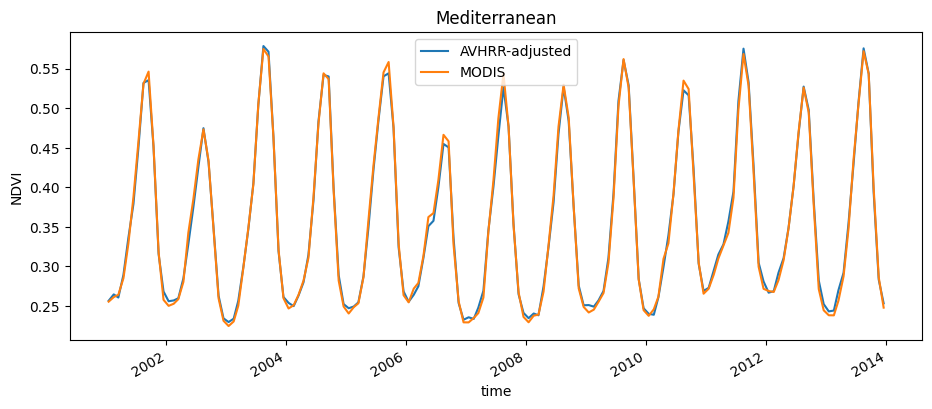

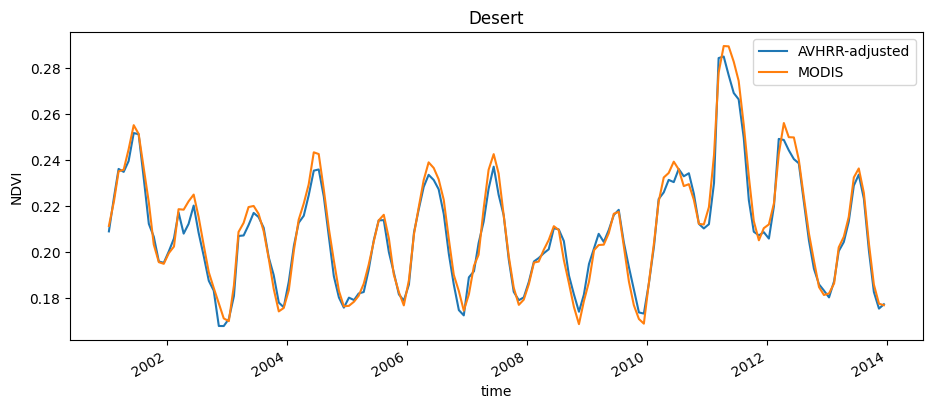

In [16]:
# Dictionary to save results 
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

for index, row in gdf.iterrows():
    
    if (name=='trees') & (row['region_name']=='Desert'):
        pass

    else:
        print(row['region_name'])
        
        # Generate a polygon mask to keep only data within the polygon
        mask = xr_rasterize(gdf.iloc[[index]], yy)
        #mask = round_coords(mask)
        
        # Mask dataset to set pixels outside the polygon to `NaN`
        ds_obs = obs.where(mask)
        ds_yy = yy.where(mask)
        
        fig, ax = plt.subplots(1,1, figsize=(11,4))
        ds_yy.mean(['x','y']).plot(ax=ax, label='AVHRR-adjusted')
        ds_obs.mean(['x','y']).plot(ax=ax, label='MODIS')
        # ax.set_ylim(0.2, 0.85)
        ax.legend()
        ax.set_title(row['region_name']);


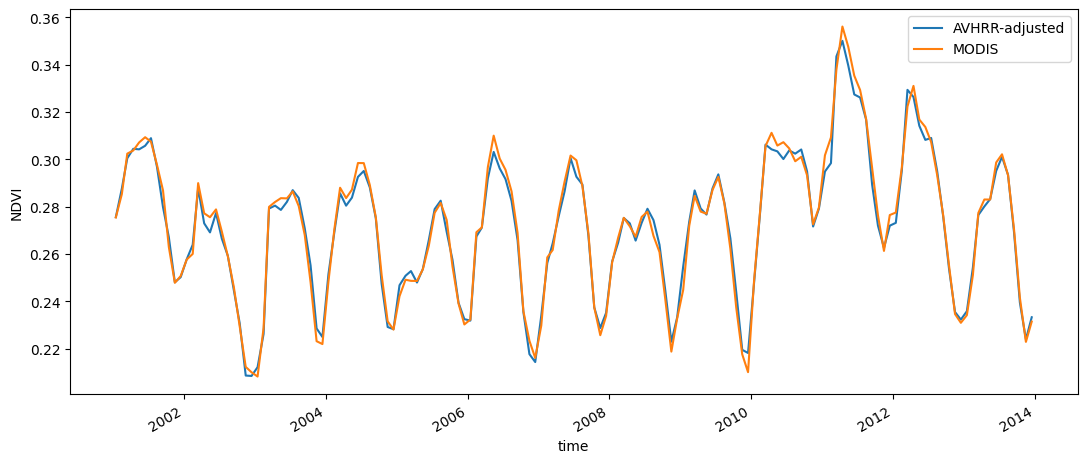

In [17]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
yy.mean(['x','y']).plot(ax=ax, label='AVHRR-adjusted')
obs.mean(['x','y']).plot(ax=ax, label='MODIS')
# ax.set_ylim(0.2, 0.85)
ax.legend()
ax.set_title('');

### Error metrics

In [18]:
corr = xr.corr(obs, yy, dim='time')
mape = xs.mape(yy, obs, dim='time', skipna=True)
rmse = xs.rmse(yy, obs, dim='time', skipna=True)
mape = mape*100
mae = xs.mae(yy, obs, dim='time', skipna=True)

mape = mape.rename('MAPE (%)')
mae = mae.rename('MAE')
corr = corr.rename('Pearson Correlation')

In [19]:
pred_mean = yy.mean('time')
obs_mean = obs.mean('time')

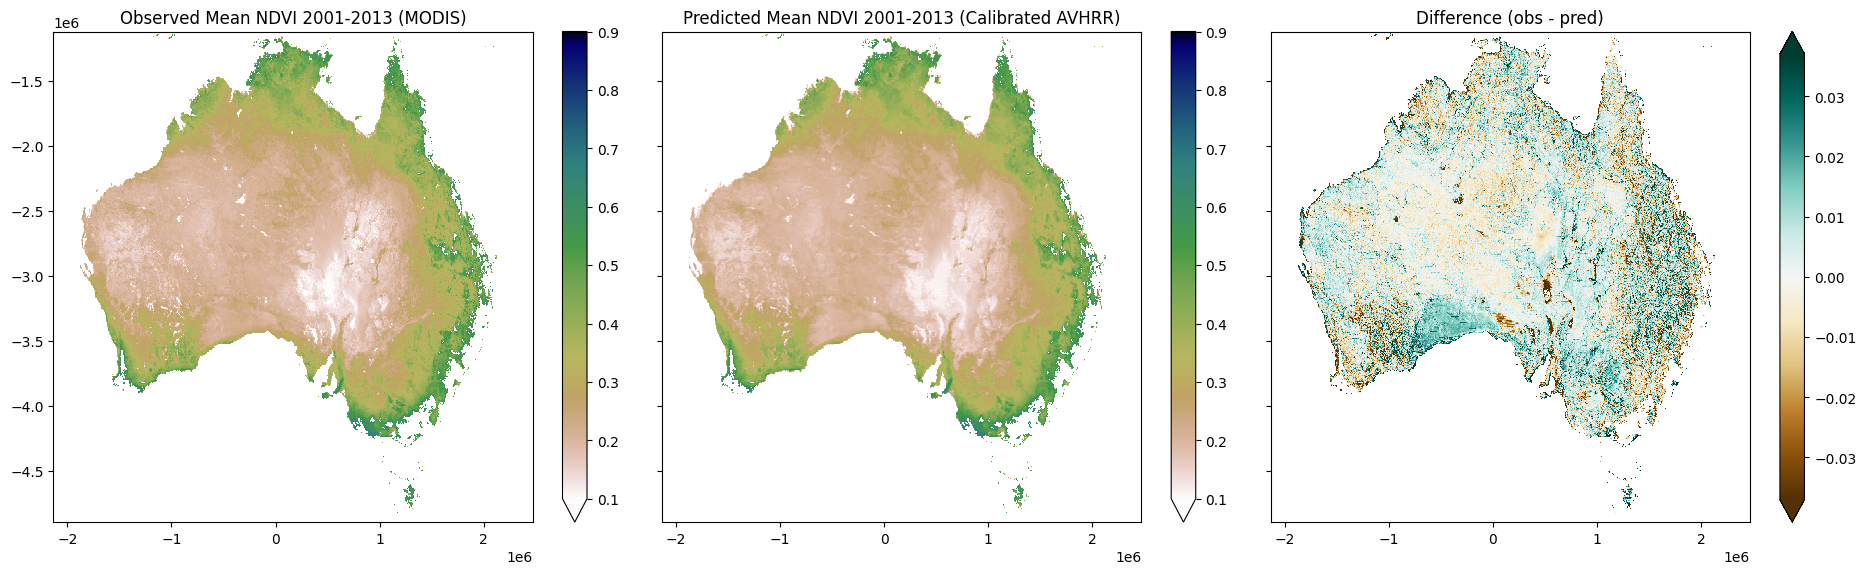

In [20]:
fig, ax = plt.subplots(1,3, figsize=(19,6), sharey=True)
vmin=0.1
vmax=0.9

obs_mean.plot.imshow(ax=ax[0], vmin=vmin,vmax=vmax, add_labels=False, cmap='gist_earth_r')
pred_mean.plot.imshow(ax=ax[1], vmin=vmin,vmax=vmax, add_labels=False, cmap='gist_earth_r')
(obs_mean - pred_mean).plot.imshow(ax=ax[2], cmap='BrBG', robust=True, add_labels=False)
ax[0].set_title('Observed Mean NDVI 2001-2013 (MODIS)')
ax[1].set_title('Predicted Mean NDVI 2001-2013 (Calibrated AVHRR)')
ax[2].set_title('Difference (obs - pred)')
plt.tight_layout()


In [21]:
# corr.plot.imshow(cmap='magma', vmin=0.0, vmax=1.0, add_labels=False, size=8)

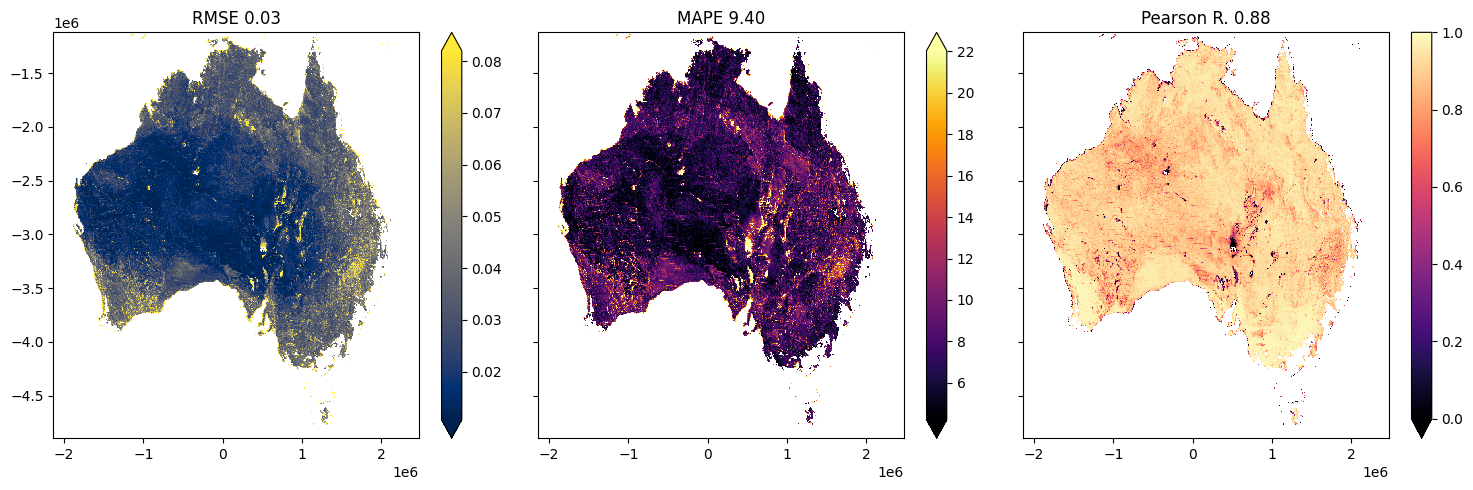

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
rmse.plot.imshow(ax=ax[0], robust=True, add_labels=False, cmap='cividis')
mape.plot.imshow(ax=ax[1], robust=True, add_labels=False, cmap='inferno')
corr.plot.imshow(ax=ax[2], cmap='magma', vmin=0.0, vmax=1.0, add_labels=False)

ax[0].set_title(f'RMSE '"{:.2f}".format(rmse.mean().values))
ax[1].set_title(f'MAPE '"{:.2f}".format(mape.mean().values))
ax[2].set_title(f'Pearson R. '"{:.2f}".format(corr.mean().values))
plt.tight_layout()

# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Error_metrics_"+model_var+"_lgbm.png",
#             bbox_inches='tight', dpi=300)

In [12]:
# m = folium.Map(control_scale = True)

# corr.odc.add_to(m, vmin=0.0, vmax=1.0, cmap='magma')
# # assign_crs(corr, crs='EPSG:4326').odc.add_to(m, robust=True, cmap='inferno')

# # Zoom map to Australia
# m.fit_bounds(corr.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)